In [15]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Install required packages
#%pip install numpy pandas xarray geopandas matplotlib shapely scipy scikit-learn 

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import snowdroughtindex package
from snowdroughtindex.core import sswei

# Configuration

In [2]:
# Configuration
config = {
    'casr_input_dir': project_root / 'data' / 'output_data' / 'merged_2d'/'1980_2024'/'bow_combined_full_data.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024'/ 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024'/'comparison',
}

# Create output directories
#config['merged_output_dir'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


# Select data for analysis

In [3]:
# Load CSV, detect datetime column, select winter season (Oct-May next year) for seasons starting 1980-2023
df = pd.read_csv(config['casr_input_dir'])

# detect a datetime-like column (common names first), otherwise try to infer
possible_names = ['date', 'datetime', 'time', 'timestamp', 'Date', 'DATE']
datetime_col = None
for name in possible_names:
    if name in df.columns:
        datetime_col = name
        break

if datetime_col is None:
    # try to find any column that parses to datetimes for majority of rows
    for col in df.columns:
        parsed = pd.to_datetime(df[col], errors='coerce')
        if parsed.notna().sum() >= 0.6 * len(df):
            datetime_col = col
            break

if datetime_col is None:
    # fallback: try the first column
    datetime_col = df.columns[0]

# create a standardized date column
df['date'] = pd.to_datetime(df[datetime_col], errors='coerce')
n_missing_dates = df['date'].isna().sum()
if n_missing_dates:
    logger.warning("Found %d rows with unparseable dates in column '%s' and they will be dropped.", n_missing_dates, datetime_col)
df = df.dropna(subset=['date']).reset_index(drop=True)

# add month/year and season_year (season starts in Oct and is labeled by its starting year)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['season_year'] = np.where(df['month'] >= 10, df['year'], df['year'] - 1)

# filter to months Oct(10) through May(5) and seasons starting between 1980 and 2023 inclusive
winter_months = [10, 11, 12, 1, 2, 3, 4, 5]
winter_df = df[df['month'].isin(winter_months) & df['season_year'].between(1980, 2023)].copy()

# optional: set date as index
winter_df = winter_df.set_index('date')

print(f"Original rows: {len(df)}; Winter rows (1980-2023 seasons): {len(winter_df)}")
winter_df.head()

Original rows: 4224309; Winter rows (1980-2023 seasons): 2750671


,Grid_id,time,lon,lat,SWE,Precipitation,Mean_Temp,Max_Temp,Humidity,Flux,Elevation_Category,month,year,season_year
date,,,,,,,,,,,,,,
1980-10-10,1,1980-10-10,-116.1380,51.3346,0.878418,0.009879,-3.783902,6.402542,0.002236,127.042317,2000_2500m,10,1980,1980
1983-10-12,2,1983-10-12,-116.1875,51.4191,6.875000,0.023846,-3.537311,8.740372,0.002839,139.681642,2000_2500m,10,1983,1983
1980-12-11,2,1980-12-11,-116.1875,51.4191,118.125000,4.578907,-7.179487,-2.481613,0.002436,19.707682,2000_2500m,12,1980,1980
1982-10-29,2,1982-10-29,-116.1875,51.4191,23.125000,1.777088,-8.325263,-1.888809,0.002016,107.054688,2000_2500m,10,1982,1982
1982-01-18,2,1982-01-18,-116.1875,51.4191,145.000000,1.890419,-16.744781,-13.240707,0.001073,46.103516,2000_2500m,1,1982,1981


In [10]:
# save the filtered winter data to a CSV file
output_file_winter = config['output_dir'] / 'bow_casr_winter_data.csv'
winter_df.to_csv(output_file_winter, index=True)
print(f"Winter data saved to {output_file_winter}")

Winter data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\bow_casr_winter_data.csv


Saved figure to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\swe_by_elevation_each_year_timeseries.png


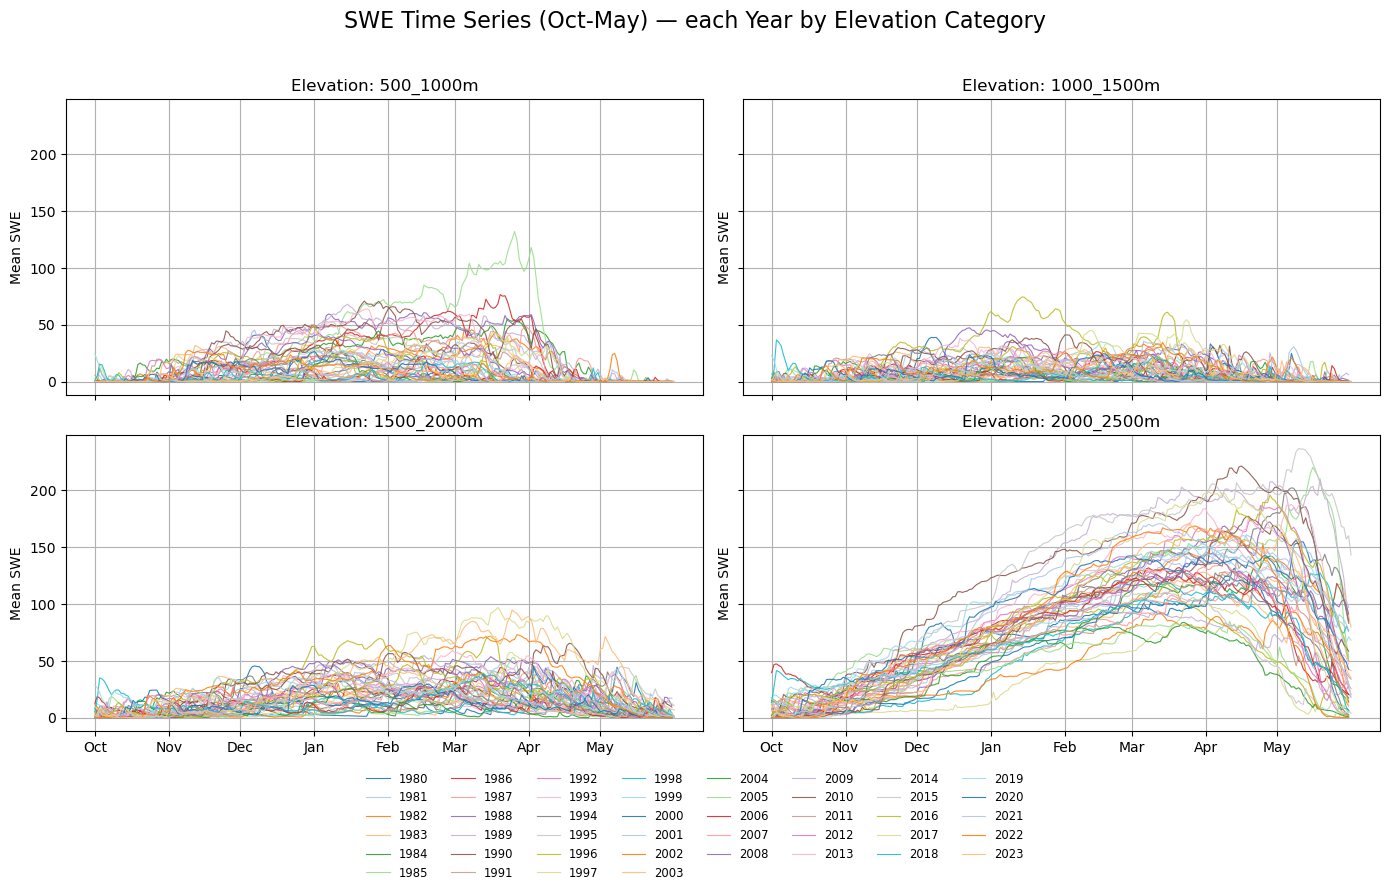

In [4]:
# Plot SWE for each season_year (Oct-May) per elevation category (up to 4 categories)
df_plot = winter_df.reset_index()  # date is a column here
cats_all = df_plot['Elevation_Category'].astype(str).unique()
cats = sorted(cats_all)[:4]  # up to 4 categories

# compute season start and season_day (days since Oct 1 of season_year)
df_plot['season_start'] = pd.to_datetime(df_plot['season_year'].astype(str) + '-10-01')
df_plot['season_day'] = (df_plot['date'] - df_plot['season_start']).dt.days

# aggregate: mean SWE across grid points for each Elevation_Category, season_year and season_day
swe_by_day = df_plot.groupby(['Elevation_Category', 'season_year', 'season_day'])['SWE'].mean()

# arrange categories in the requested order (keep only those present)
desired_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
cats = [c for c in desired_order if c in list(cats_all)]

# fallback to previous selection if none of the desired categories are found
if not cats:
    cats = sorted(cats_all)[:4]

# ensure plot dir exists
config['plots'].mkdir(parents=True, exist_ok=True)

# create subplots
n = len(cats)
ncols = 2
nrows = (n + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=True, sharey=True)
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

# color map for many years
cmap = plt.get_cmap('tab20')

for i, cat in enumerate(cats):
    ax = axes_flat[i]
    tbl = swe_by_day.loc[cat].unstack('season_year')  # index=season_day, columns=season_year
    tbl = tbl.sort_index(axis=1)  # ensure years sorted
    years = tbl.columns.tolist()
    for j, yr in enumerate(years):
        ax.plot(tbl.index, tbl[yr], label=str(yr), color=cmap(j % 20), lw=0.8, alpha=0.9)
    ax.set_title(f"Elevation: {cat}")
    ax.set_ylabel("Mean SWE")
    ax.grid(True)
    # prevent the per-axis legend (later "if i == 0: ax.legend(...)") from showing
    ax.legend = lambda *args, **kwargs: None
    # create a single figure-level legend (use the first axis which has all year lines)
    if i == 0:
        lines = ax.get_lines()
        labels = [ln.get_label() for ln in lines]
        # keep unique labels in order
        seen = set()
        uniq_handles = []
        uniq_labels = []
        for h, lbl in zip(lines, labels):
            if lbl in seen:
                continue
            seen.add(lbl)
            uniq_handles.append(h)
            uniq_labels.append(lbl)
        fig.legend(uniq_handles, uniq_labels, ncol=8, loc='lower center',
                   bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
    if i == 0:
        ax.legend(ncol=4, fontsize='small', loc='upper left')

# hide unused axes
for j in range(len(cats), len(axes_flat)):
    axes_flat[j].set_visible(False)

# x-axis ticks: month labels from Oct -> May using a reference season_start
season_start_ref = pd.to_datetime('2000-10-01')
xticks_days = []
xtick_labels = []
for m in range(10, 13):
    dt = pd.to_datetime(f'2000-{m:02d}-01')
    xticks_days.append((dt - season_start_ref).days)
    xtick_labels.append(dt.strftime('%b'))
for m in range(1, 6):
    dt = pd.to_datetime(f'2001-{m:02d}-01')
    xticks_days.append((dt - season_start_ref).days)
    xtick_labels.append(dt.strftime('%b'))
for ax in axes_flat[:len(cats)]:
    ax.set_xticks(xticks_days)
    ax.set_xticklabels(xtick_labels)

fig.suptitle("SWE Time Series (Oct-May) — each Year by Elevation Category", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

out_file = config['plots'] / "swe_by_elevation_each_year_timeseries.png"
fig.savefig(out_file, dpi=150)
print(f"Saved figure to {out_file}")
plt.show()

# 1. Standardized SWEI Calculation

In [5]:
# Calculate daily SWE change considering each coordinate_id
# ensure rows are ordered by Grid_id, season_year and date so diff is computed in temporal order
swe_df = winter_df.reset_index().sort_values(['Grid_id', 'season_year', 'date']).set_index('date')

# compute next-day SWE change per grid and season (difference to next row within group)
swe_df['daily_SWE_change'] = swe_df.groupby(['Grid_id', 'season_year'])['SWE'].diff().shift(-1)
swe_df['daily_SWE_change'] = swe_df['daily_SWE_change'].fillna(0)
swe_df.loc[swe_df['daily_SWE_change'] < 0, 'daily_SWE_change'] = 0

# drop precipitation, mean_Temp, Max_Temp, Humidity, Flux, month, year, date columns if they exist
cols_to_drop = ['Precipitation', 'Mean_Temp', 'Max_Temp', 'Humidity', 'Flux', 'month', 'year', 'date']
existing = [c for c in cols_to_drop if c in swe_df.columns]
if existing:
	swe_df = swe_df.drop(columns=existing)

# Display the updated DataFrame
display(swe_df)


,Grid_id,time,lon,lat,SWE,Elevation_Category,season_year,daily_SWE_change
date,,,,,,,,
1980-10-01,1,1980-10-01,-116.1380,51.3346,1.382812,2000_2500m,1980,0.367188
1980-10-02,1,1980-10-02,-116.1380,51.3346,1.750000,2000_2500m,1980,0.000000
1980-10-03,1,1980-10-03,-116.1380,51.3346,0.761230,2000_2500m,1980,0.000000
1980-10-04,1,1980-10-04,-116.1380,51.3346,0.382812,2000_2500m,1980,0.000000
1980-10-05,1,1980-10-05,-116.1380,51.3346,0.127930,2000_2500m,1980,0.000000
...,...,...,...,...,...,...,...,...
2024-05-27,257,2024-05-27,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000
2024-05-28,257,2024-05-28,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000
2024-05-29,257,2024-05-29,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000


In [6]:
# 1. perturb zeros

swe_df['perturb_SWE'] = sswei.perturb_zeros(swe_df['daily_SWE_change'])

display(swe_df)

,Grid_id,time,lon,lat,SWE,Elevation_Category,season_year,daily_SWE_change,perturb_SWE
date,,,,,,,,,
1980-10-01,1,1980-10-01,-116.1380,51.3346,1.382812,2000_2500m,1980,0.367188,3.671875e-01
1980-10-02,1,1980-10-02,-116.1380,51.3346,1.750000,2000_2500m,1980,0.000000,3.041151e-06
1980-10-03,1,1980-10-03,-116.1380,51.3346,0.761230,2000_2500m,1980,0.000000,2.814000e-06
1980-10-04,1,1980-10-04,-116.1380,51.3346,0.382812,2000_2500m,1980,0.000000,1.444076e-06
1980-10-05,1,1980-10-05,-116.1380,51.3346,0.127930,2000_2500m,1980,0.000000,1.254327e-06
...,...,...,...,...,...,...,...,...,...
2024-05-27,257,2024-05-27,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000,2.638298e-07
2024-05-28,257,2024-05-28,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000,1.193237e-07
2024-05-29,257,2024-05-29,-111.6202,50.0960,0.000000,500_1000m,2023,0.000000,2.869618e-06


In [10]:
# 2. SWE Integration (fixed)

def integrate_season(group: pd.DataFrame) -> pd.Series:
    """
    Integrate SWE values over a season for each Grid_id / season_year / Elevation_Category.
    This version ensures we use datetime objects (either the index or 'time'/'date' columns)
    for arithmetic so we avoid str - str subtraction errors.
    """
    # Determine a datetime index to use
    if np.issubdtype(group.index.dtype, np.datetime64):
        time_index = group.index
    else:
        if 'time' in group.columns:
            time_index = pd.to_datetime(group['time'], errors='coerce')
        elif 'date' in group.columns:
            time_index = pd.to_datetime(group['date'], errors='coerce')
        else:
            raise ValueError("No datetime-like column found in group for integration")
    # drop rows with missing times or missing SWE
    valid_mask = (~pd.isna(time_index)) & (~pd.isna(group['SWE']))
    if not valid_mask.any():
        # return NaN integration if no valid data
        return pd.Series({
            'Grid_id': group['Grid_id'].iloc[0] if 'Grid_id' in group.columns else np.nan,
            'season_year': group['season_year'].iloc[0] if 'season_year' in group.columns else np.nan,
            'Elevation_Category': group['Elevation_Category'].iloc[0] if 'Elevation_Category' in group.columns else None,
            'total_SWE_integration': np.nan
        })
    time_index = pd.to_datetime(time_index[valid_mask])
    swe_vals = group['SWE'].values[valid_mask]

    # sort by time to ensure proper integration
    order = np.argsort(time_index)
    time_index = time_index[order]
    swe_vals = swe_vals[order]

    # compute days since start as numeric x values for trapz
    days_since_start = (time_index - time_index.min()).total_seconds() / 86400.0

    # Integrate SWE over the season
    total_swe_integration = trapz(swe_vals, days_since_start)

    return pd.Series({
        'Grid_id': group['Grid_id'].iloc[0],
        'season_year': group['season_year'].iloc[0],
        'Elevation_Category': group['Elevation_Category'].iloc[0],
        'total_SWE_integration': total_swe_integration
    })

# Apply the integration function to each group of Grid_id and season_year and Elevation_Category
SWE_integration = swe_df.groupby(['Grid_id', 'season_year', 'Elevation_Category']).apply(integrate_season).reset_index(drop=True)

display(SWE_integration)

,Grid_id,season_year,Elevation_Category,total_SWE_integration
0,1,1980,2000_2500m,30295.246322
1,1,1981,2000_2500m,34403.204364
2,1,1982,2000_2500m,34199.671012
3,1,1983,2000_2500m,27932.422855
4,1,1984,2000_2500m,26921.058586
...,...,...,...,...
11303,257,2019,500_1000m,571.779053
11304,257,2020,500_1000m,579.107177
11305,257,2021,500_1000m,283.044342
11306,257,2022,500_1000m,743.058776


In [11]:
# 3. Gringorten plotting position calculation
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability'] = SWE_integration.groupby('Grid_id')['total_SWE_integration'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,season_year,Elevation_Category,total_SWE_integration,gringorten_probability
0,1,1980,2000_2500m,30295.246322,0.556664
1,1,1981,2000_2500m,34403.204364,0.737987
2,1,1982,2000_2500m,34199.671012,0.692656
3,1,1983,2000_2500m,27932.422855,0.420671
4,1,1984,2000_2500m,26921.058586,0.352675
...,...,...,...,...,...
11303,257,2019,500_1000m,571.779053,0.239347
11304,257,2020,500_1000m,579.107177,0.262013
11305,257,2021,500_1000m,283.044342,0.012693
11306,257,2022,500_1000m,743.058776,0.466002


In [12]:
#4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
SWE_integration['SSWEI'] = SWE_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,season_year,Elevation_Category,total_SWE_integration,gringorten_probability,SSWEI
0,1,1980,2000_2500m,30295.246322,0.556664,0.142516
1,1,1981,2000_2500m,34403.204364,0.737987,0.637153
2,1,1982,2000_2500m,34199.671012,0.692656,0.503394
3,1,1983,2000_2500m,27932.422855,0.420671,-0.200177
4,1,1984,2000_2500m,26921.058586,0.352675,-0.378110
...,...,...,...,...,...,...
11303,257,2019,500_1000m,571.779053,0.239347,-0.708404
11304,257,2020,500_1000m,579.107177,0.262013,-0.637153
11305,257,2021,500_1000m,283.044342,0.012693,-2.235488
11306,257,2022,500_1000m,743.058776,0.466002,-0.085324


In [15]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = SWE_integration.groupby(['season_year', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='season_year', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1980,-0.778473,-0.630553,-0.346771,-0.087648
1,1981,0.320094,-0.022423,0.090731,0.605933
2,1982,-0.942805,-0.050002,0.072459,0.618429
3,1983,-0.358285,-0.266688,-0.307029,0.474398
4,1984,-0.147442,0.176385,-0.214268,0.994070
5,1985,0.314323,0.575974,0.860058,1.250473
6,1986,-0.474813,0.062905,0.006162,0.569811
7,1987,-1.338402,-0.326762,-0.616191,0.386472
8,1988,0.898300,1.037102,0.378059,1.295822
9,1989,0.113604,1.057718,1.412421,1.065104


In [17]:
# 5. Classification

# Apply the classify_drought function to each value in the average_SSWEI column
# Apply the classify_drought function to each elevation column
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    average_SSWEI_per_year[f'Classification_{col}'] = average_SSWEI_per_year[col].apply(sswei.classify_drought)

# Do not rename columns here, as the DataFrame now has more columns after classification
# If you want to keep only certain columns, select them explicitly, e.g.:
# average_SSWEI_per_year = average_SSWEI_per_year[['Season_year', '1000_1500m', 'Classification_1000_1500m', ...]]

#remove decimal points from season year
average_SSWEI_per_year['season_year'] = average_SSWEI_per_year['season_year'].astype(int)

# Display the updated DataFrame
display(average_SSWEI_per_year)

Elevation_Category,season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m,Classification_500_1000m
0,1980,-0.778473,-0.630553,-0.346771,-0.087648,Moderate Drought,Moderate Drought,Near Normal,Near Normal
1,1981,0.320094,-0.022423,0.090731,0.605933,Near Normal,Near Normal,Near Normal,Abnormally Wet
2,1982,-0.942805,-0.050002,0.072459,0.618429,Moderate Drought,Near Normal,Near Normal,Abnormally Wet
3,1983,-0.358285,-0.266688,-0.307029,0.474398,Near Normal,Near Normal,Near Normal,Near Normal
4,1984,-0.147442,0.176385,-0.214268,0.994070,Near Normal,Near Normal,Near Normal,Abnormally Wet
5,1985,0.314323,0.575974,0.860058,1.250473,Near Normal,Abnormally Wet,Abnormally Wet,Moderately Wet
6,1986,-0.474813,0.062905,0.006162,0.569811,Near Normal,Near Normal,Near Normal,Abnormally Wet
7,1987,-1.338402,-0.326762,-0.616191,0.386472,Severe Drought,Near Normal,Moderate Drought,Near Normal
8,1988,0.898300,1.037102,0.378059,1.295822,Abnormally Wet,Moderately Wet,Near Normal,Moderately Wet
9,1989,0.113604,1.057718,1.412421,1.065104,Near Normal,Moderately Wet,Moderately Wet,Moderately Wet


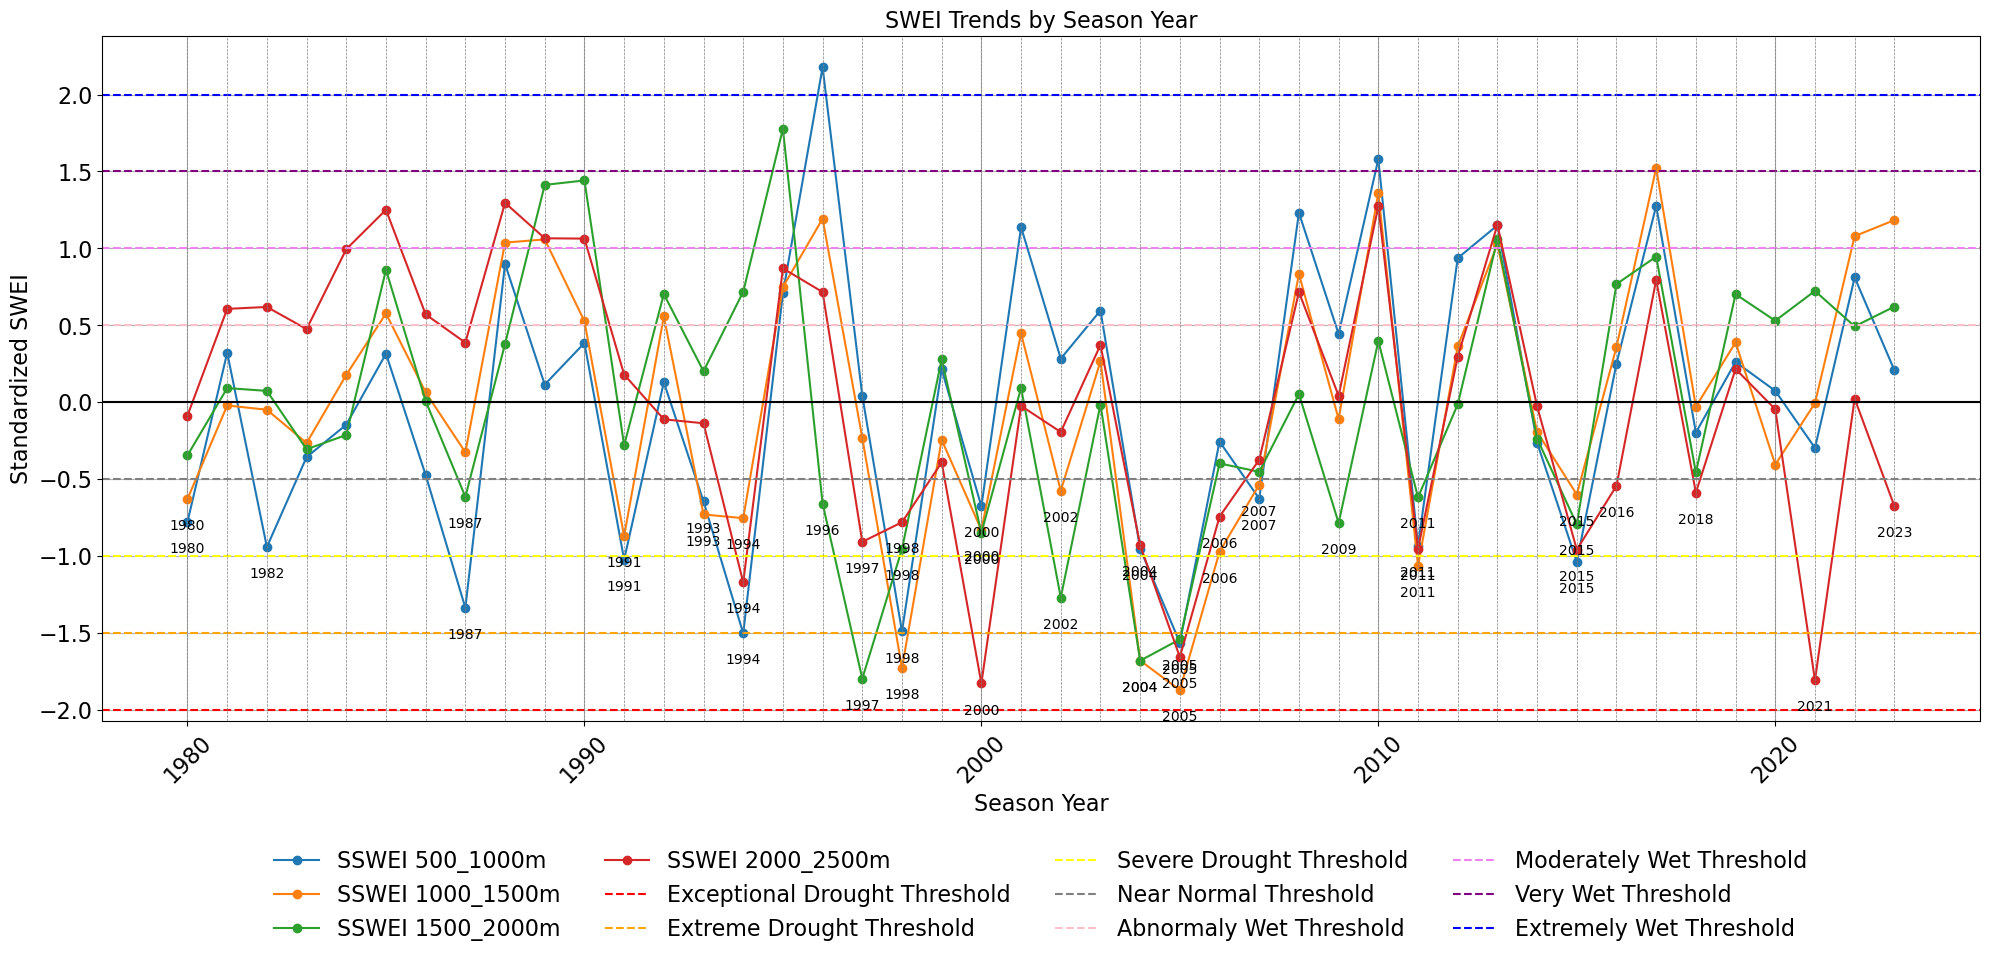

In [21]:
#6. Plotting the results
# Prepare data for plotting
plot_data = average_SSWEI_per_year.sort_values(by='season_year')
plt.figure(figsize=(20, 10))
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    plt.plot(plot_data['season_year'], plot_data[col], marker='o', label=f'SSWEI {col}')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
#z = np.polyfit(plot_data['Season_year'], plot_data['SSWEI'], 1)
#p = np.poly1d(z)
#plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year',fontsize=16)
plt.xlabel('Season Year',fontsize=16)
plt.ylabel('Standardized SWEI',fontsize=16)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
# put legend outside the plot right top 
plt.legend(['SSWEI 500_1000m', 'SSWEI 1000_1500m', 'SSWEI 1500_2000m', 'SSWEI 2000_2500m',
            'Exceptional Drought Threshold', 'Extreme Drought Threshold', 'Severe Drought Threshold',
            'Near Normal Threshold', 'Abnormaly Wet Threshold', 'Moderately Wet Threshold',
            'Very Wet Threshold', 'Extremely Wet Threshold'],
           loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4, fontsize=16, frameon=False)
# Add gridlines for each year
for year in plot_data['season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
# Add years to SSWEI < -0.5 for each elevation category
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    for i, row in plot_data.iterrows():
        if row[col] < -0.5:
            plt.text(row['season_year'], row[col] - 0.2, str(row['season_year']), fontsize=10, color='black', ha='center')
plt.grid()
plt.axhline(0, color='black', linewidth=1.5, linestyle='-', label='y=0')
plt.tight_layout()
plt.savefig(config['plots'] /  'SWEI_trends.png')
plt.show()
plt.close()

2025-10-27 22:29:22,383 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-27 22:29:22,387 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-27 22:29:22,389 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-27 22:29:22,391 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-27 22:29:22,394 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved monthly SWEI plot for 2023 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\SWEI_2023_monthly_by_elevation.png


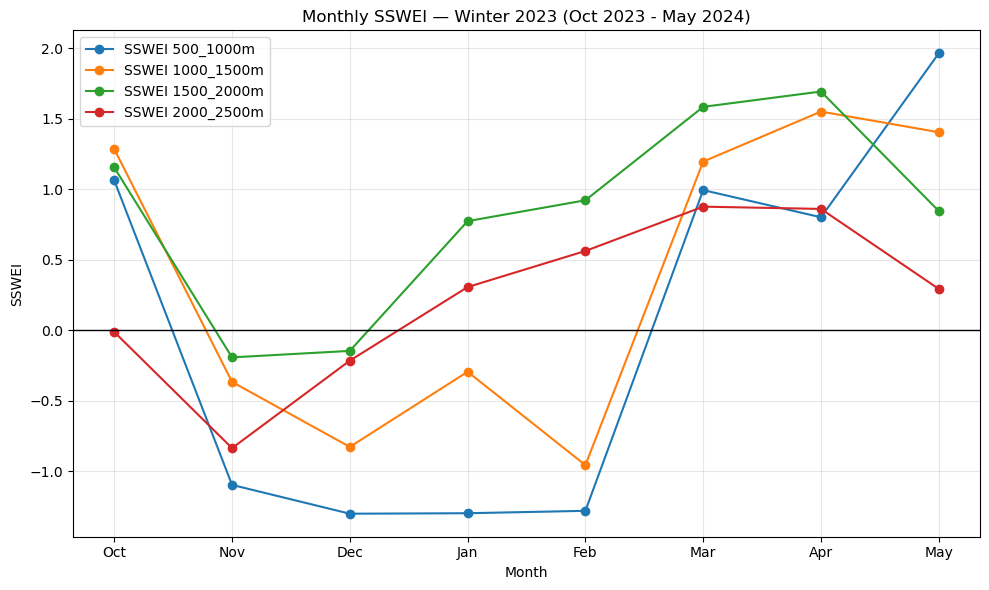

In [23]:
# Filter for winter season 2023 (season_year == 2023 -> Oct 2023 through May 2024),
# compute monthly integrated SWE per Grid_id & Elevation_Category, compute gringorten prob & SSWEI,
# then plot mean SSWEI per month for the four elevation categories.

# months order and labels
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
elev_order = [c for c in ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m'] if c in swe_df['Elevation_Category'].unique()]

# prepare DataFrame with date column
# Reset index so the datetime index becomes a column; this handles both cases where the index
# is named 'date' or unnamed (becomes 'index').
df_month = swe_df.reset_index()

# if reset_index created a column named 'index' but we expect 'date', rename it
if 'date' not in df_month.columns and 'index' in df_month.columns:
    df_month = df_month.rename(columns={'index': 'date'})

# ensure date is datetime
df_month['date'] = pd.to_datetime(df_month['date'], errors='coerce')

# add a 'month' column required later (fixes KeyError: 'month')
if 'month' not in df_month.columns:
    df_month['month'] = df_month['date'].dt.month

# ensure season_year exists (same convention used elsewhere: Oct-Dec -> season_year = year,
# Jan-May -> season_year = year - 1). Only create if missing.
if 'season_year' not in df_month.columns:
    df_month['season_year'] = df_month['date'].dt.year.where(df_month['date'].dt.month >= 10,
                                                             df_month['date'].dt.year - 1)

# integration function for one month-group
def integrate_month(group: pd.DataFrame) -> float:
    # time index (group['date'] exists because we reset_index)
    times = pd.to_datetime(group['date'], errors='coerce')
    valid = (~times.isna()) & (~group['SWE'].isna())
    if valid.sum() == 0:
        return np.nan
    t = times[valid].sort_values()
    swe_vals = group.loc[valid, 'SWE'].iloc[t.index.get_indexer(t)].values
    # days since start of the month window
    days = (t - t.min()).dt.total_seconds() / 86400.0
    return float(trapz(swe_vals, days))

# compute monthly integration per Grid_id, season_year, month, Elevation_Category
monthly_integration = (
    df_month
    .loc[df_month['month'].isin(months_order), ['Grid_id', 'season_year', 'month', 'Elevation_Category', 'date', 'SWE']]
    .groupby(['Grid_id', 'season_year', 'month', 'Elevation_Category'], observed=True)
    .apply(lambda g: pd.Series({'monthly_swe_integration': integrate_month(g)}))
    .reset_index()
)

# compute gringorten probabilities grouped by Grid_id and month (across years)
def safe_gringorten(arr):
    try:
        return sswei.gringorten_probabilities(arr)
    except Exception:
        # fallback: empirical plotting position (rank / (n+1))
        arr = np.asarray(arr, dtype=float)
        ranks = pd.Series(arr).rank(method='average').values
        n = len(arr)
        return ranks / (n + 1)

monthly_integration['gringorten_probability'] = (
    monthly_integration
    .groupby(['Grid_id', 'month'], observed=True)['monthly_swe_integration']
    .transform(lambda x: safe_gringorten(x.values))
)

# compute SSWEI from gringorten_probability per Grid_id & month
def safe_compute_swei(arr):
    try:
        return sswei.compute_swei(arr)
    except Exception:
        # fallback using inverse normal (approx)
        return norm.ppf(arr)

monthly_integration['SSWEI'] = (
    monthly_integration
    .groupby(['Grid_id', 'month'], observed=True)['gringorten_probability']
    .transform(lambda x: safe_compute_swei(x.values))
)

# select season 2023 rows and aggregate mean SSWEI per month and elevation
monthly_2023 = monthly_integration[monthly_integration['season_year'] == 2023].copy()
mean_monthly = (
    monthly_2023
    .groupby(['month', 'Elevation_Category'], observed=True)['SSWEI']
    .mean()
    .reset_index()
    .pivot(index='month', columns='Elevation_Category', values='SSWEI')
)

# reindex months and elevation order
mean_monthly = mean_monthly.reindex(index=months_order).reset_index()
mean_monthly['month_label'] = [month_labels[i] for i in range(len(months_order))]

# plotting
plt.figure(figsize=(10, 6))
for elev in elev_order:
    if elev in mean_monthly.columns:
        plt.plot(mean_monthly['month_label'], mean_monthly[elev], marker='o', label=f'SSWEI {elev}')

plt.title('Monthly SSWEI — Winter 2023 (Oct 2023 - May 2024)')
plt.xlabel('Month')
plt.ylabel('SSWEI')
plt.axhline(0, color='black', linewidth=1)
plt.grid(alpha=0.3)
plt.legend(loc='best')
out_path = config['plots'] / 'SWEI_2023_monthly_by_elevation.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
print(f"Saved monthly SWEI plot for 2023 to: {out_path}")
plt.show()

# SPI calculation

In [8]:
# Extract precipitation time series for SPI calculations (monthly and seasonal totals)
# Assumes `winter_df` (filtered to Oct-May) already exists in the notebook.

df_prec = winter_df.reset_index()  # bring date back as a column if it's the index

# keep only the requested columns (rename to lowercase names for consistency)
_keep = ['date', 'Grid_id', 'lon', 'lat', 'Precipitation', 'Elevation_Category', 'month', 'season_year']
_available = [c for c in _keep if c in df_prec.columns]
df_prec = df_prec[_available].rename(columns={
    'Grid_id': 'Grid_id',
    'Precipitation': 'Precipitation',
    'Elevation_Category': 'Elevation_Category',
    'season_year': 'Season_year'
})

# ensure date is datetime
df_prec['date'] = pd.to_datetime(df_prec['date'], errors='coerce')

display(df_prec.head())

,date,Grid_id,lon,lat,Precipitation,Elevation_Category,month,Season_year
0,1980-10-10,1,-116.1380,51.3346,0.009879,2000_2500m,10,1980
1,1983-10-12,2,-116.1875,51.4191,0.023846,2000_2500m,10,1983
2,1980-12-11,2,-116.1875,51.4191,4.578907,2000_2500m,12,1980
3,1982-10-29,2,-116.1875,51.4191,1.777088,2000_2500m,10,1982
4,1982-01-18,2,-116.1875,51.4191,1.890419,2000_2500m,1,1981


In [10]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    df_prec
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = df_prec[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

,Grid_id,Season_year,date,Precipitation,Elevation_Category
0,1,1980,1980-10-31,15.461886,2000_2500m
1,1,1980,1980-11-30,50.295086,2000_2500m
2,1,1980,1980-12-31,108.955549,2000_2500m
3,1,1980,1981-01-31,13.916898,2000_2500m
4,1,1980,1981-02-28,38.431036,2000_2500m


In [12]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year date                                                             
1980        1980-10-31     23.722882     32.100595     23.455035    27.613888
            1980-11-30     23.173287     32.786186     52.304052    12.598151
            1980-12-31     24.672522     39.349471     94.355993    27.466716
            1981-01-31      6.245697      9.145041     11.316449     8.226255
            1981-02-28      8.437483     13.018755     29.459216     4.767321
            1981-03-31     15.564112     10.314856     14.930461    22.119542
            1981-04-30      7.126947     12.134646     29.451566     7.069899
            1981-05-31    133.068552    162.022685     95.782016    96.181287
1981        1981-10-31     20.885100     15.466855     33.907494    22.720848
            1981-11-30      4.466762      6.709451     12.339459     7.268729

In [13]:
# Save the combined data to a CSV file
output_file_precip = config['output_dir'] / 'bow_casr_winter_precipitation_data.csv'
monthly_avg.to_csv(output_file_precip, index=True)


SPI - 8

In [14]:
# Group by season and sum the precipitation for each column
seasonal_precip = monthly_avg.groupby('Season_year').sum(numeric_only=True)

display(seasonal_precip)


,1000_1500m_P,1500_2000m_P,2000_2500m_P,500_1000m_P
Season_year,,,,
1980,242.011482,310.872235,351.054789,206.043058
1981,171.030216,193.174389,291.108212,160.440271
1982,156.795298,205.542866,243.835041,117.648657
1983,137.950856,189.299702,258.186900,110.003974
1984,116.997037,184.783056,244.739935,140.387278
1985,164.864539,219.291349,331.202378,119.285645
1986,100.427064,157.675500,258.874716,91.564115
1987,87.722122,149.274611,258.678127,54.590393
1988,152.237207,211.979476,276.572095,116.466092


In [16]:
# Calculate SPI for each elevation column and season year
spi_results = {}

for col in seasonal_precip.columns:
    # Drop NaNs and non-positive values for SPI calculation
    precip = seasonal_precip[col].dropna()
    precip = precip[precip > 0]  # Only positive values
    if len(precip) < 10:  # Not enough data to fit
        spi_results[col.replace('_P', '_SPI')] = [float('nan')] * len(seasonal_precip)
        continue
    shape, loc, scale = gamma.fit(precip, floc=0)
    cdf = gamma.cdf(seasonal_precip[col], shape, loc=loc, scale=scale)
    #cdf = cdf.clip(1e-10, 1 - 1e-10)  # Avoid exactly 0 or 1
    spi = norm.ppf(cdf)
    spi_results[col.replace('_P', '_SPI')] = spi

# Combine SPI results into a DataFrame
spi_df = pd.DataFrame(spi_results, index=seasonal_precip.index)

display(spi_df.tail(20))

,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
Season_year,,,,
2004,-0.846991,-0.911534,-0.699333,-1.368231
2005,-0.957269,-1.322759,-0.873862,0.276581
2006,1.061388,0.127216,1.354495,1.869389
2007,0.886514,1.034454,0.506064,-0.058830
2008,-0.022649,-0.158597,-0.562560,-0.359796
2009,0.547848,-0.138778,-1.395304,2.081513
2010,2.072322,1.576848,0.885386,1.605807
2011,0.798770,0.768847,1.275185,1.035127
2012,1.523647,1.419827,1.029248,1.489081


Saved monthly SWEI plot for 2023 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\SPI_8.png


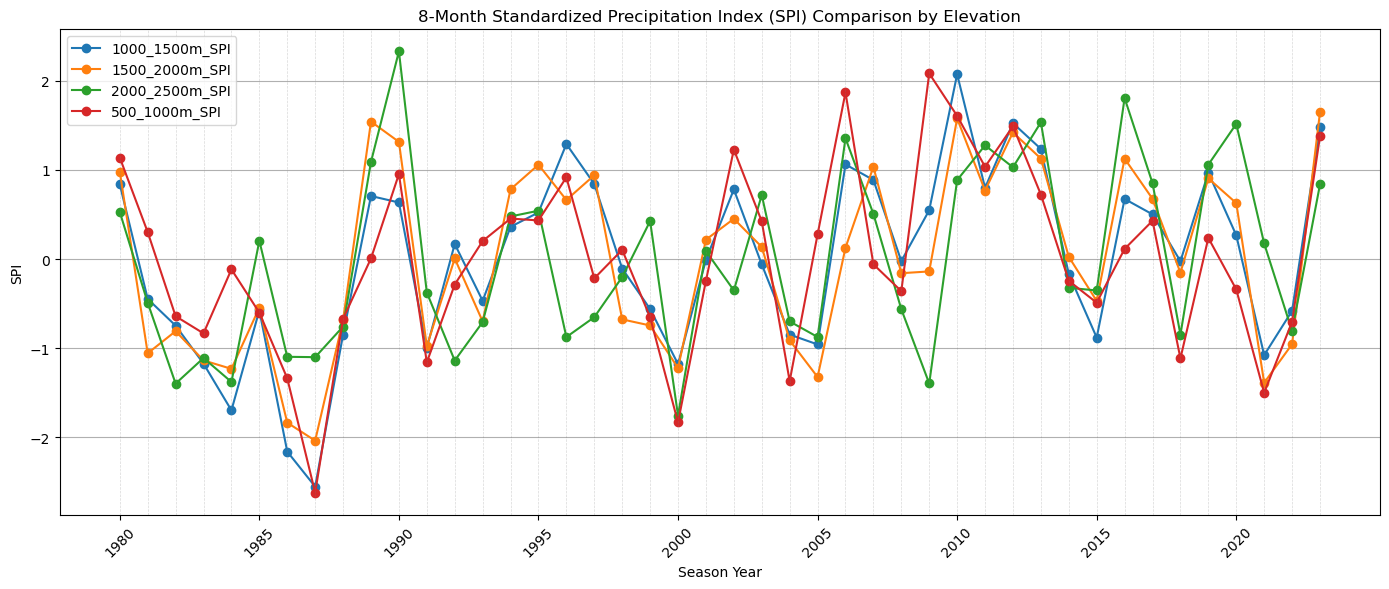

In [19]:
# Plot all SPI columns from spi_df on the same graph for comparison
plt.figure(figsize=(14, 6))
for col in spi_df.columns:
    plt.plot(spi_df.index, spi_df[col], marker='o', label=col)

plt.xlabel('Season Year')
plt.ylabel('SPI')
plt.title('8-Month Standardized Precipitation Index (SPI) Comparison by Elevation')
plt.legend()
plt.grid(True, axis='y')
for year in spi_df.index:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(
    ticks=spi_df.index[::5],  # every 5th year
    labels=spi_df.index[::5],
    rotation=45
)
out_path = config['plots'] / 'SPI_8.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
print(f"Saved monthly SWEI plot for 2023 to: {out_path}")
plt.show()